In [ ]:
import torch
from peft import PeftModel

from src.controller import Controller
from src.flux import FluxControllerPipeline

In [3]:
pipe = FluxControllerPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev", 
    torch_dtype=torch.bfloat16
)

if getattr(pipe, "transformer", None):      pipe.transformer.requires_grad_(False)
if getattr(pipe, "vae", None):              pipe.vae.requires_grad_(False)
if getattr(pipe, "text_encoder", None):     pipe.text_encoder.requires_grad_(False)
if getattr(pipe, "text_encoder_2", None):   pipe.text_encoder_2.requires_grad_(False)
if getattr(pipe, "text_encoder_3", None):   pipe.text_encoder_3.requires_grad_(False)
print("Model loaded")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded


In [4]:
# ONLY NEEDED FOR SMALL VRAM
pipe.enable_sequential_cpu_offload()
pipe.transformer.enable_gradient_checkpointing()

from functools import partial
pipe.transformer.enable_gradient_checkpointing(
    gradient_checkpointing_func=partial(torch.utils.checkpoint.checkpoint, use_reentrant=False)
)

  0%|          | 0/25 [00:00<?, ?it/s]

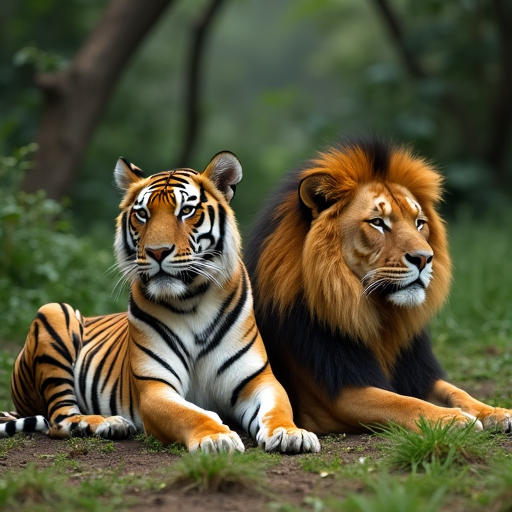

In [5]:
SEED = 5
STEPS = 25
GUIDANCE = 3.5
SIZE = 512
PROMPT = "A lion and a tiger resting side by side in a jungle clearing"

controller = Controller(
    t5_ids = [[2], [7, 8]],
    clip_ids = [[2], [5]],
    lambda_scale=4,
    heuristic="focus", # "conform", "focus", "attend_and_excite", "divide_and_bind"
    model="FLUX"
)

output_controller = pipe(
    PROMPT,
    num_inference_steps=STEPS,
    guidance_scale=GUIDANCE,
    height=SIZE,
    width=SIZE,
    max_sequence_length=256,
    generator=torch.Generator("cpu").manual_seed(SEED),
    controller=controller,
    num_images_per_prompt=1
).images[0]

output_controller

  0%|          | 0/25 [00:00<?, ?it/s]

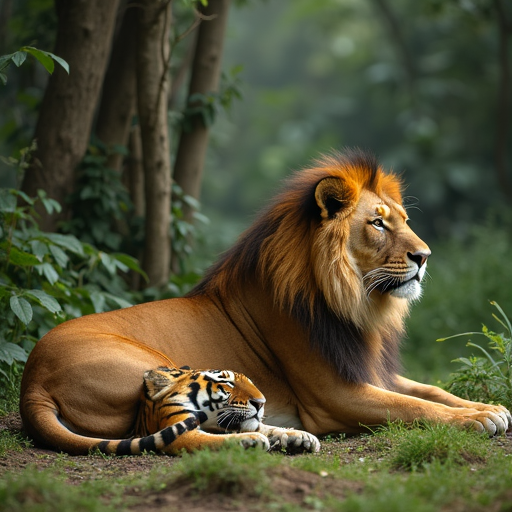

In [6]:
output_base = pipe(
    PROMPT,
    num_inference_steps=STEPS,
    guidance_scale=GUIDANCE,
    height=SIZE,
    width=SIZE,
    max_sequence_length=256,
    generator=torch.Generator("cpu").manual_seed(SEED),
    controller=None,
).images[0]

output_base